# Marginalizing over Discretes

##### Keywords: marginalizing over discretes, mixture model, gaussian mixture model, log-sum-exp trick, pymc3

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
import theano.tensor as tt

In [2]:
data=np.loadtxt("data/3g.dat")
data.shape

(1000,)

## Class Model for 3 gaussian mixture

```python
with pm.Model() as mof2:
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=3)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))

    # cluster centers
    means = pm.Normal('means', mu=[0, 10, 20], sd=5, shape=3)

    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))
                                         
    # measurement error
    sds = pm.Uniform('sds', lower=0, upper=20, shape=3)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=data.shape[0])

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sds[category],
                       observed=data)
```

## The log-sum-exp trick and mixtures

From the Stan Manual:

>The log sum of exponentials function is used to define mixtures on the log scale. It is defined for two inputs by

$$log\_sum\_exp(a, b) = log(exp(a) + exp(b)).$$

>If a and b are probabilities on the log scale, then $exp(a) + exp(b)$ is their sum on the linear scale, and the outer log converts the result back to the log scale; to summarize, log_sum_exp does linear addition on the log scale. The reason to use the built-in log_sum_exp function is that it can prevent underflow and overflow in the exponentiation, by calculating the result as

$$log \left( exp(a) + exp(b) \right)  = c + log  exp(a − c) + exp(b − c)  ,$$

>where c = max(a, b). In this evaluation, one of the terms, a − c or b − c, is zero and the other is negative, thus eliminating the possibility of overflow or underflow in the leading term and eking the most arithmetic precision possible out of the operation.

As one can see below, `pymc3` uses the same definition

From https://github.com/pymc-devs/pymc3/blob/master/pymc3/math.py#L27

```python
def logsumexp(x, axis=None):
    # Adapted from https://github.com/Theano/Theano/issues/1563
    x_max = tt.max(x, axis=axis, keepdims=True)
    return tt.log(tt.sum(tt.exp(x - x_max), axis=axis, keepdims=True)) + x_max
```

For example (as taken from the Stan Manual), the mixture of $N(−1, 2)$ and $N(3, 1)$ with mixing proportion $\lambda = (0.3, 0.7)$:

$$logp(y \vert \lambda, \mu, \sigma)$$

$$= log\left(0.3×N(y \vert −1,2) + 0.7×N(y \vert 3,1)\right)$$

$$= log\left(exp(log(0.3 × N(y \vert − 1, 2)))  + exp(log(0.7 × N(y \vert 3, 1))) \right)$$

$$= \mathtt{log\_sum\_exp}\left(log(0.3) + log\,N(y \vert − 1, 2), log(0.7) + log\, N(y \vert 3, 1) \right).$$

where `log_sum_exp` is the function as defined above.

This generalizes to the case of more mixture components.

This is thus a custon distribution `logp` we must define. If we do this, we can go directly from the Dirichlet priors for $p$ and forget the `category` variable

## Pymc3 implements the log-sum-exp directly

Lets see the source here to see how its done:

https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/mixture.py

There is a marginalized Gaussian Mixture model available, as well as a general mixture. We'll use the `NormalMixture`, to which we must provide mixing weights and components.

In [5]:
with pm.Model() as mof3:
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=3)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))
    means = pm.Normal('means', mu=[0, 20, 40], sd=5, shape=3)

    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # measurement error
    sds = pm.Uniform('sds', lower=0, upper=20, shape=3)

    points = pm.NormalMixture('obs', p, mu=means, sd=sds, observed=data)


INFO (theano.gof.compilelock): Refreshing lock /Users/rahul/.theano/compiledir_Darwin-16.1.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock


In [6]:
with mof3:
    tripletrace_full3 = pm.sample(10000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sds_interval__, means, p_stickbreaking__]
100%|██████████| 12000/12000 [01:02<00:00, 191.03it/s]


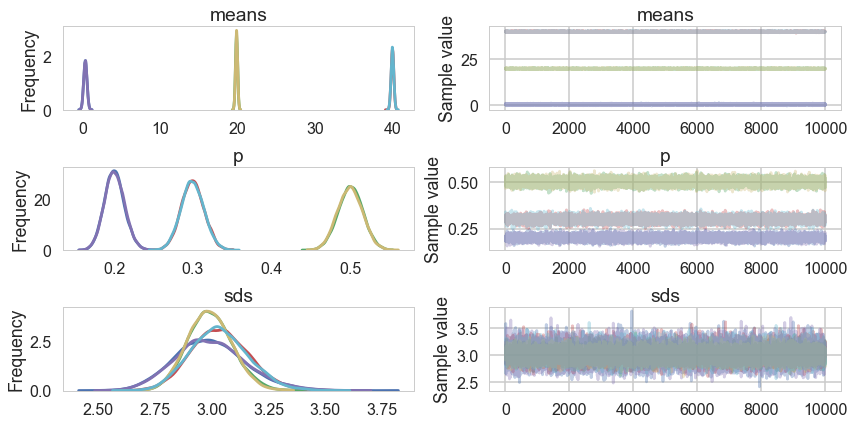

In [7]:
pm.traceplot(tripletrace_full3);

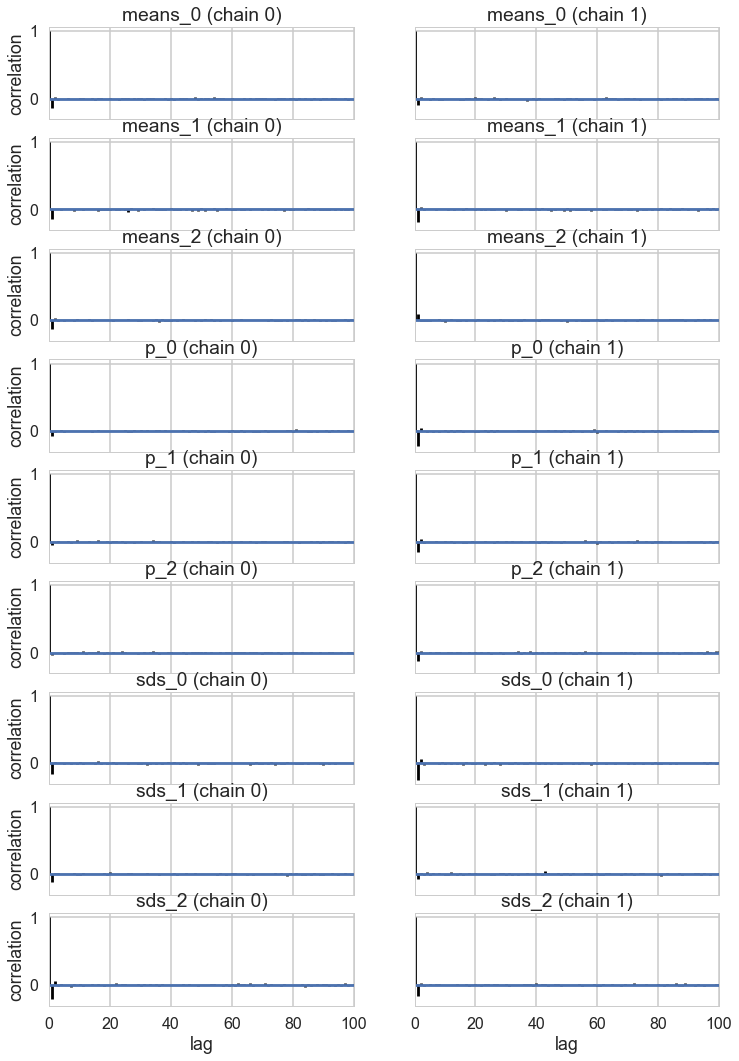

In [8]:
pm.autocorrplot(tripletrace_full3);

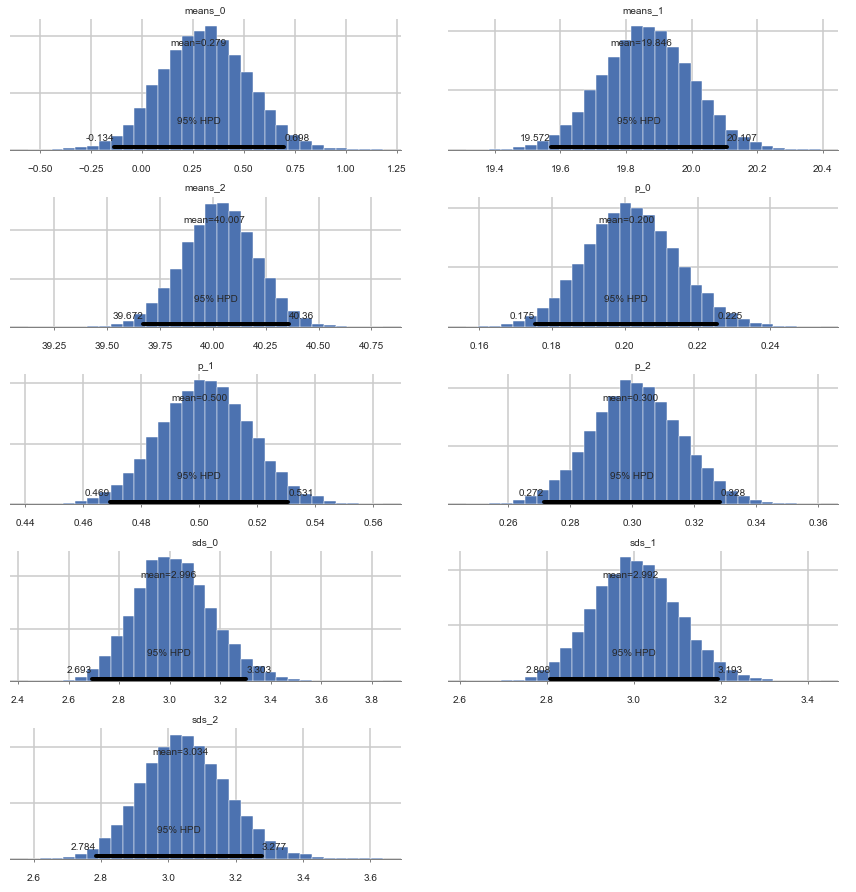

In [9]:
pm.plot_posterior(tripletrace_full3);

## Posterior Predictive

In [10]:
with mof3:
    ppc_trace = pm.sample_ppc(tripletrace_full3, 5000)

100%|██████████| 5000/5000 [00:04<00:00, 1064.44it/s]


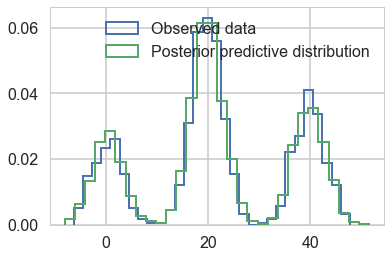

In [11]:
plt.hist(data, bins=30, normed=True,
        histtype='step', lw=2,
        label='Observed data');
plt.hist(ppc_trace['obs'], bins=30, normed=True,
        histtype='step', lw=2,
        label='Posterior predictive distribution');

plt.legend(loc=1);

You can see the general agreement between these two distributions in this posterior predictive check!

## By Hand

We need to write out the `logp` for the likelihood ourself now, using `logsumexp` to do the sum we need.

In [24]:
from pymc3.math import logsumexp


def logp_normal(mu, sigma, value):
    # log probability of individual samples
    delta = lambda mu: value - mu
    return (-1 / 2.) * (tt.log(2 * np.pi) + tt.log(sigma*sigma) +
                         (delta(mu)* delta(mu))/(sigma*sigma))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pis, sigmas, n_samples, n_components):
                        
    def logp_(value):        
        logps = [tt.log(pis[i]) + logp_normal(means[i], sigmas[i], value)
                 for i in range(n_components)]
            
        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

In [26]:
with pm.Model() as mof2:
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=3)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))

    # cluster centers
    means = pm.Normal('means', mu=[0, 10, 20], sd=5, shape=3)

    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))
                                         
    # measurement error
    sds = pm.Uniform('sds', lower=0, upper=20, shape=3)

    # latent cluster of each observation
#     category = pm.Categorical('category',
#                               p=p,
#                               shape=data.shape[0])

    # likelihood for each observed valueDensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)
    points = pm.DensityDist('obs', logp_gmix(means, p, sds, data.shape[0], 3),
                       observed=data)

INFO (theano.gof.compilelock): Refreshing lock /Users/rahul/.theano/compiledir_Darwin-16.1.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock


In [30]:
with mof2:
    tripletrace_full2 = pm.sample(10000, tune=2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sds_interval__, means, p_stickbreaking__]
100%|██████████| 12000/12000 [00:38<00:00, 310.05it/s]


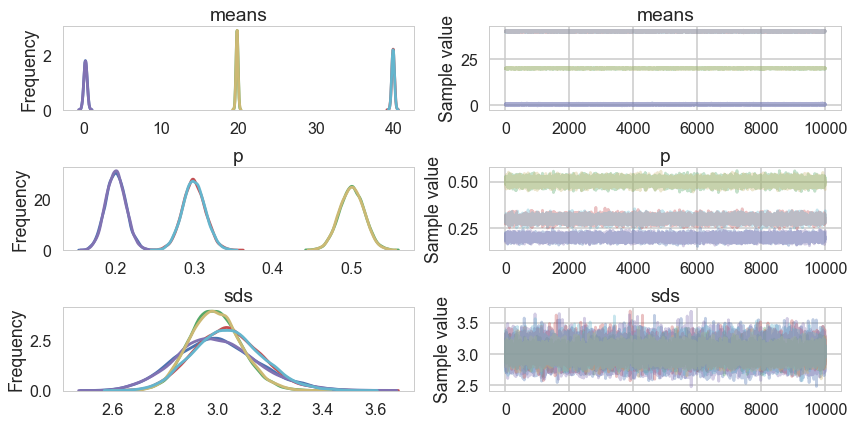

In [31]:
pm.traceplot(tripletrace_full2);

In [33]:
tripletrace_full2[0]

{'means': array([ -2.63567074e-02,   1.97651323e+01,   4.00719437e+01]),
 'p': array([ 0.21479503,  0.49260884,  0.29259613]),
 'p_stickbreaking__': array([-0.60311337,  0.52092218]),
 'sds': array([ 2.95977013,  2.88030396,  3.12347716]),
 'sds_interval__': array([-1.75046541, -1.78233378, -1.68697662])}

### Posterior predictive

You cant use `sample_ppc` directly because we did not create a sampling function for our DensityDist. But this is easy to do for a mixture model. Sample a categorical from the p's above, and then sample the appropriate gaussian.

>Exercise: Write a function to do this!

In [32]:
with mof2:
    ppc_trace2 = pm.sample_ppc(tripletrace_full2, 5000)

  0%|          | 0/5000 [00:00<?, ?it/s]


AttributeError: 'DensityDist' object has no attribute 'random'